In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

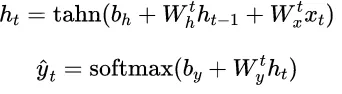

In [ ]:
class RNNCell(nn.Module):
    
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(RNNCell, self).__init__()
        self.Wx = torch.randn(hiddenSize, inputSize) # input weights
        self.Wh = torch.randn(hiddenSize, hiddenSize) # hidden weights
        self.Wy = torch.randn(outputSize,hiddenSize) # output weights
        self.h = torch.zeros(hiddenSize,1) # initial hidden state
        self.bh = torch.zeros(hiddenSize,1) # hidden state bias
        self.by = torch.zeros(outputSize,1) # output bias
        
    def forward(self, x):
        self.h = torch.tanh(self.bh + torch.matmul(self.Wx, x) + torch.matmul(self.Wh,self.h))
        output = nn.Softmax(self.by + torch.matmul(self.Wy,self.h))
        
        return output, self.h

In [ ]:
model = RNNCell(1, 20, 1)

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate input data
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

# Convert data to PyTorch tensors
x = torch.from_numpy(x).float().unsqueeze(1)
y = torch.from_numpy(y).float().unsqueeze(1)

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.Wxh = nn.Linear(input_size, hidden_size)
        self.Whh = nn.Linear(hidden_size, hidden_size)
        self.Why = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        h_prev = torch.zeros(x.size(0), self.hidden_size)

        for t in range(x.size(1)):
            h_t = self.tanh(self.Wxh(x[:, t, :]) + self.Whh(h_prev))
            h_prev = h_t

        output = self.Why(h_t)
        return output

# Set hyperparameters
input_size = 1
hidden_size = 32
output_size = 1

# Create the RNN model
model = RNN(input_size, hidden_size, output_size)

# Compute the explicit formulas for the forward pass
h_prev = torch.zeros(1, hidden_size)
Wxh = model.Wxh.weight
Whh = model.Whh.weight
Why = model.Why.weight

for t in range(x.size(1)):
    x_t = x[:, t, :]
    linear1 = torch.matmul(x_t, Wxh.t())
    linear2 = torch.matmul(h_prev, Whh.t())
    h_t = torch.tanh(linear1 + linear2)
    h_prev = h_t

output = torch.matmul(h_t, Why.t())

# Compare the computed output with the model's output
print("Computed output:", output.item())
model_output = model(x)
print("Model output:", model_output.item())


In [ ]:
# sin

In [ ]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

In [ ]:
SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
T = 20 # Period of Sin Function
L = 1000 # Sample Lenght of Sin function
N = 200   # Sequence Length

In [ ]:
x = np.empty((N, L), 'int32')
x[:] = np.array(range(L))
data = np.sin(x * (1.0 / T)).astype('float32')
x_f = np.array(range(1500))
data_f = np.sin(x_f * (1.0 / T)).astype('float32')

In [ ]:
print("x", x.shape)
print("x[:]", x[:].shape)
print("data", data.shape)
print("x_f", x_f.shape)
print("data_f", data_f.shape)

In [ ]:
print(x)

In [ ]:
print(x[:])

In [ ]:
print(data)

In [ ]:
print(x_f)

In [ ]:
print(data_f)

In [ ]:
train_data = torch.from_numpy(data[1:, :-1])
print(train_data)

In [ ]:
test_data = torch.from_numpy(data[:1, :-1])
print(test_data)

In [ ]:
train_target = torch.from_numpy(data[1:, 1:])
print(train_target)

In [ ]:
test_target = torch.from_numpy(data[:1, 1:])
print(test_target)

In [ ]:
class RNNSin(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super(RNNSin, self).__init__()
        self.rnn = nn.RNNCell(in_dim, h_dim)
        self.linear = nn.Linear(h_dim, out_dim)
        self.h_dim = h_dim

    def forward(self, train_data, future = 0):
        outputs = []        
        h_t = torch.zeros((train_data.size(0),self.h_dim))
        for i, input_t in enumerate(train_data.chunk(train_data.size(1), dim=1)):
            h_t = self.rnn(input_t,h_t)
            output = self.linear(h_t)
            outputs.append(output)
        for i in range(future):            
            h_t = self.rnn(outputs[-1],h_t)
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [ ]:
seq = RNNCell(1,200,1)        

In [ ]:
loss_fn = nn.MSELoss()
optimizer = optim.LBFGS(seq.parameters(), lr=0.4)
Nepochs = 15

In [ ]:
fig, ax = plt.subplots(figsize=(30,15))
image_list = []
for it in range(Nepochs):
    
    
    def closure():
        optimizer.zero_grad()
        out = seq(train_data)
        loss = loss_fn(out, train_target)
        print('\rEpoch:', it,'loss:', loss.item(), end='')
        loss.backward()
        return loss
    optimizer.step(closure)
    
    future = 500
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred = seq(test_data, future=future)
        loss = loss_fn(pred[:, :-future], test_target)
        print(' test loss:', loss.item())
        y = pred.detach().numpy()
    plt.cla()
    ax.set_xlabel('x', fontsize=26)
    ax.set_ylabel('y', fontsize=26)
    ax.set_xlim([0,1600])
    ax.set_ylim([-1.5, 1.5])
    ax.plot(x_f, data_f, "-r", linewidth = 3.0, label="Actual Series")
    ax.plot(np.arange(train_data.size(1)), y[0][:train_data.size(1)], '--k', linewidth = 2.0, label="Training")
    ax.plot(np.arange(train_data.size(1), train_data.size(1) + future), y[0][train_data.size(1):], 'b' + ':', linewidth = 3.0, label="Test + Future")
    ax.vlines(1000, -1.5, 1.5, colors="black", linestyles='solid', linewidth=2.0)   
    ax.text(500.0, 1.4, 'It = %d,' %it, fontdict={'size': 26, 'color':  'black'})
    plt.legend(loc=2, prop={'size': 20})
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    image_list.append(image)
#imageio.mimsave('./RNN_sine_1.gif', image_list, duration=200)



print("train_data", train_data.shape)
print("train_target", train_target.shape)
print("test_data", test_data.shape)
print("test_target", test_target.shape)

In [ ]:
seq(train_data)

In [ ]:
train_data

In [ ]:
print("test_target", test_target.shape)

In [ ]:
T = 20 # Period of Sin Function
L = 1000 # Sample Lenght of Sin function
N = 200   # Sequence Length


x = np.empty((N, L), 'int32')
x[:] = np.array(range(L))
data = np.sin(x * (1.0 / T)).astype('float32')
x_f = np.array(range(1500))
data_f = np.sin(x_f * (1.0 / T)).astype('float32')

train_data = torch.from_numpy(data[1:, :-1])
train_target = torch.from_numpy(data[1:, 1:])
test_data = torch.from_numpy(data[:1, :-1])
test_target = torch.from_numpy(data[:1, 1:])

print(train_data.shape)

In [ ]:
print(train_target.shape)

In [ ]:
print(test_data.shape)

In [ ]:
print(test_target.shape)

In [ ]:
x.shape

In [ ]:
x[:].shape

In [ ]:
x[:]

In [ ]:
k = np.array(range(10))

In [ ]:
data

In [ ]:
k = seq(test_data, future=future)

In [ ]:
k.shape

In [ ]:
future

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate training data
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

# Convert data to PyTorch tensors
x_train = torch.Tensor(x).view(-1, 1, 1)
y_train = torch.Tensor(y).view(-1, 1)

# Define the RNNCell model
class RNNCell(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(RNNCell, self).__init__()
        self.Wx = nn.Parameter(torch.randn(hiddenSize, inputSize))  # input weights
        self.Wh = nn.Parameter(torch.randn(hiddenSize, hiddenSize))  # hidden weights
        self.Wy = nn.Parameter(torch.randn(outputSize, hiddenSize))  # output weights
        self.bh = nn.Parameter(torch.zeros(hiddenSize, 1))  # hidden state bias
        self.by = nn.Parameter(torch.zeros(outputSize, 1))  # output bias

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        h = torch.zeros(batch_size, self.Wh.size(0), 1)  # initial hidden state

        outputs = []
        for t in range(seq_len):
            h = torch.tanh(self.bh + torch.matmul(self.Wx, x[:, t, :].unsqueeze(2)) + torch.matmul(self.Wh, h))
            output = nn.Softmax(dim=1)(self.by + torch.matmul(self.Wy, h))
            outputs.append(output)

        return torch.stack(outputs, dim=1), h

# Set hyperparameters
inputSize = 1
hiddenSize = 200
outputSize = 1
num_epochs = 1000
learning_rate = 0.001

# Initialize the RNNCell model
model = RNNCell(inputSize, hiddenSize, outputSize)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    outputs, _ = model(x_train)
    loss = criterion(outputs[:, -1, :], y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Test the model
model.eval()
with torch.no_grad():
    x_test = torch.Tensor(np.linspace(0, 2*np.pi, 1000)).view(-1, 1, 1)
    y_pred, _ = model(x_test)
    y_pred = y_pred[:, -1, :].numpy().flatten()

# Plot the results
plt.plot(x, y, label='sin(x)')
plt.plot(x_test.numpy().flatten(), y_pred, label='RNNCell Approximation')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate training data
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

# Normalize the input data
x_mean, x_std = np.mean(x), np.std(x)
y_mean, y_std = np.mean(y), np.std(y)
x_normalized = (x - x_mean) / x_std
y_normalized = (y - y_mean) / y_std

# Convert data to PyTorch tensors
x_train = torch.Tensor(x_normalized).view(-1, 1, 1)
y_train = torch.Tensor(y_normalized).view(-1, 1)

# Define the RNNCell model
class RNNCell(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(RNNCell, self).__init__()
        self.Wx = nn.Parameter(torch.randn(hiddenSize, inputSize))  # input weights
        self.Wh = nn.Parameter(torch.randn(hiddenSize, hiddenSize))  # hidden weights
        self.Wy = nn.Parameter(torch.randn(outputSize, hiddenSize))  # output weights
        self.bh = nn.Parameter(torch.zeros(hiddenSize, 1))  # hidden state bias
        self.by = nn.Parameter(torch.zeros(outputSize, 1))  # output bias

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        h = torch.zeros(batch_size, self.Wh.size(0), 1)  # initial hidden state

        outputs = []
        for t in range(seq_len):
            h = torch.tanh(self.bh + torch.matmul(self.Wx, x[:, t, :].unsqueeze(2)) + torch.matmul(self.Wh, h))
            output = nn.Softmax(dim=1)(self.by + torch.matmul(self.Wy, h))
            outputs.append(output)

        return torch.stack(outputs, dim=1), h

# Set hyperparameters
inputSize = 1
hiddenSize = 64
outputSize = 1
num_epochs = 1000
learning_rate = 0.001

# Initialize the RNNCell model
model = RNNCell(inputSize, hiddenSize, outputSize)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    outputs, _ = model(x_train)
    loss = criterion(outputs[:, -1, :], y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Test the model
model.eval()
with torch.no_grad():
    x_test = torch.Tensor(np.linspace(0, 2*np.pi, 1000)).view(-1, 1, 1)
    y_pred, _ = model(x_test)
    y_pred = (y_pred[:, -1, :] * y_std) + y_mean
    y_pred = y_pred.numpy().flatten()

# Plot the results
plt.plot(x, y, label='sin(x)')
plt.plot(x_test.numpy().flatten(), y_pred, label='RNNCell Approximation')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate training data
x = np.linspace(0, 2 * np.pi, 1000)
y = np.sin(x)

# Normalize the input data
x_mean, x_std = np.mean(x), np.std(x)
y_mean, y_std = np.mean(y), np.std(y)
x_normalized = (x - x_mean) / x_std
y_normalized = (y - y_mean) / y_std

# Convert data to PyTorch tensors
x_train = torch.Tensor(x_normalized).view(-1, 1, 1)
y_train = torch.Tensor(y_normalized).view(-1, 1)

# Define the RNNCell model
class RNNCell(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(RNNCell, self).__init__()
        self.hiddenSize = hiddenSize
        self.rnn = nn.RNN(inputSize, hiddenSize, batch_first=True)
        self.fc = nn.Linear(hiddenSize, outputSize)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last output only
        return out

# Set hyperparameters
inputSize = 1
hiddenSize = 200
outputSize = 1
num_epochs = 10000
learning_rate = 0.001

# Initialize the RNNCell model
model = RNNCell(inputSize, hiddenSize, outputSize)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Test the model
model.eval()
with torch.no_grad():
    x_test = torch.Tensor(np.linspace(0, 2*np.pi, 1000)).view(-1, 1, 1)
    y_pred = model(x_test).numpy().flatten()

# Scale the predictions back to the original range
y_pred = (y_pred * y_std) + y_mean

# Plot the results
plt.plot(x, y, label='sin(x)')
plt.plot(x, y_pred, label='RNNCell Approximation')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate training data
x = np.linspace(0, 2 * np.pi, 1000)
y = np.sin(x)

# # Normalize the input data
# x_mean, x_std = np.mean(x), np.std(x)
# y_mean, y_std = np.mean(y), np.std(y)
# x_normalized = (x - x_mean) / x_std
# y_normalized = (y - y_mean) / y_std

# Convert data to PyTorch tensors
x_train = torch.Tensor(x).view(-1, 1, 1)
y_train = torch.Tensor(y).view(-1, 1)

# Define the RNNCell model
class RNNCell(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(RNNCell, self).__init__()
        self.Wx = nn.Parameter(torch.randn(hiddenSize, inputSize))  # input weights
        self.Wh = nn.Parameter(torch.randn(hiddenSize, hiddenSize))  # hidden weights
        self.Wy = nn.Parameter(torch.randn(outputSize, hiddenSize))  # output weights
        self.bh = nn.Parameter(torch.zeros(hiddenSize, 1))  # hidden state bias
        self.by = nn.Parameter(torch.zeros(outputSize, 1))  # output bias

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        h = torch.zeros(batch_size, self.Wh.size(0), 1)  # initial hidden state

        outputs = []
        for t in range(seq_len):
            h = torch.tanh(self.bh + torch.matmul(self.Wx, x[:, t, :].unsqueeze(2)) + torch.matmul(self.Wh, h))
            output = nn.Softmax(dim=1)(self.by + torch.matmul(self.Wy, h))
            outputs.append(output)

        return torch.stack(outputs, dim=1), h

# Set hyperparameters
inputSize = 1
hiddenSize = 20
outputSize = 1
num_epochs = 1000
learning_rate = 0.1

# Initialize the RNNCell model
model = RNNCell(inputSize, hiddenSize, outputSize)

# Define the loss function
criterion = nn.MSELoss()

# Define the closure for LBFGS
def closure():
    optimizer.zero_grad()
    outputs, _ = model(x_train)
    loss = criterion(outputs[:, -1, :], y_train)
    loss.backward()
    return loss

# Initialize the LBFGS optimizer
optimizer = optim.LBFGS(model.parameters(), lr=learning_rate, max_iter=2000)

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.step(closure)

    if (epoch + 1) % 100 == 0:
        with torch.no_grad():
            outputs, _ = model(x_train)
            loss = criterion(outputs[:, -1, :], y_train)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Test the model
model.eval()
with torch.no_grad():
    x_test = torch.Tensor(np.linspace(0, 2 * np.pi, 1000)).view(-1, 1, 1)
    y_pred, _ = model(x_test)
#     y_pred = (y_pred[:, -1, :] * y_std) + y_mean
#     y_pred = y_pred.numpy().flatten()

# # Scale the predictions back to the original range
# y_pred = (y_pred * y_std) + y_mean

# Plot the results
plt.plot(x, y, label='sin(x)')
plt.plot(x_test.numpy().flatten(), y_pred, label='RNNCell Approximation')
plt.legend()
plt.show()

In [ ]:
### 7th July|


In [ ]:
import torch
import torch.nn as nn
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate input data
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)





# Convert data to PyTorch tensors
x = torch.from_numpy(x).unsqueeze(1).float()
y = torch.from_numpy(y).unsqueeze(1).float()

# Define the RNN cell
class RNNCell(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(RNNCell, self).__init__()
        self.Wx = nn.Parameter(torch.randn(hiddenSize, inputSize))  # input weights
        self.Wh = nn.Parameter(torch.randn(hiddenSize, hiddenSize))  # hidden weights
        self.Wy = nn.Parameter(torch.randn(outputSize, hiddenSize))  # output weights
        self.h = torch.zeros(hiddenSize, 1)  # initial hidden state
        self.bh = nn.Parameter(torch.zeros(hiddenSize, 1))  # hidden state bias
        self.by = nn.Parameter(torch.zeros(outputSize, 1))  # output bias

    def forward(self, x):
        outputs = []
        for t in range(x.size(0)):
            self.h = torch.tanh(self.bh + torch.matmul(self.Wx, x[t]) + torch.matmul(self.Wh, self.h))
            output = nn.functional.softmax(self.by + torch.matmul(self.Wy, self.h), dim=0)
            outputs.append(output)
        return torch.stack(outputs, dim=0), self.h

# Set hyperparameters
inputSize = 1
hiddenSize = 32
outputSize = 1
learningRate = 0.01
numEpochs = 100

# Create the RNN model
model = RNNCell(inputSize, hiddenSize, outputSize)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

# Training loop
for epoch in range(numEpochs):
    model.train()
    outputs, _ = model(x)
    loss = criterion(outputs, y)

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{numEpochs}, Loss: {loss.item()}")

# Predict with the trained model
model.eval()
with torch.no_grad():
    predictions, _ = model(x)

# Print some predictions
for i in range(10):
    print("Input:", x[i].item(), "True output:", y[i].item(), "Predicted output:", predictions[i].item())


In [ ]:
import torch
import torch.nn as nn
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate input data
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

# Convert data to PyTorch tensors
x = torch.from_numpy(x).unsqueeze(1).float()
y = torch.from_numpy(y).unsqueeze(1).float()

# Define the RNN cell
class RNNCell(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(RNNCell, self).__init__()
        self.Wx = nn.Parameter(torch.randn(hiddenSize, inputSize))  # input weights
        self.Wh = nn.Parameter(torch.randn(hiddenSize, hiddenSize))  # hidden weights
        self.Wy = nn.Parameter(torch.randn(outputSize, hiddenSize))  # output weights
        self.h = torch.zeros(hiddenSize, 1)  # initial hidden state  # initial hidden state
        self.bh = nn.Parameter(torch.zeros(hiddenSize, 1))  # hidden state bias
        self.by = nn.Parameter(torch.zeros(outputSize, 1))  # output bias

    def forward(self, x):
        outputs = []
        for t in range(x.size(0)):
            self.h = torch.tanh(self.bh + torch.matmul(self.Wx, x[t]) + torch.matmul(self.Wh, self.h))
            output = nn.functional.softmax(self.by + torch.matmul(self.Wy, self.h), dim=0)
            outputs.append(output)
        return torch.stack(outputs, dim=0), self.h

# Set hyperparameters
inputSize = 1
hiddenSize = 32
outputSize = 1
learningRate = 0.01
numEpochs = 100

# Create the RNN model
model = RNNCell(inputSize, hiddenSize, outputSize)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

# Training loop
for epoch in range(numEpochs):
    model.train()
    outputs, _ = model(x)
    loss = criterion(outputs, y)

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{numEpochs}, Loss: {loss.item()}")

# Predict with the trained model
model.eval()
with torch.no_grad():
    predictions, _ = model(x)

# Print some predictions
for i in range(10):
    print("Input:", x[i].item(), "True output:", y[i].item(), "Predicted output:", predictions[i].item())


In [ ]:
import torch
import torch.nn as nn
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate input data
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

# Convert data to PyTorch tensors
x = torch.from_numpy(x).unsqueeze(1).float()
y = torch.from_numpy(y).unsqueeze(1).float()

# Define the RNN cell
class RNNCell(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(RNNCell, self).__init__()
        self.Wx = nn.Parameter(torch.randn(hiddenSize, inputSize))  # input weights
        self.Wh = nn.Parameter(torch.randn(hiddenSize, hiddenSize))  # hidden weights
        self.Wy = nn.Parameter(torch.randn(outputSize, hiddenSize))  # output weights
        self.h = torch.zeros(hiddenSize, 1)  # initial hidden state
        self.bh = nn.Parameter(torch.zeros(hiddenSize, 1))  # hidden state bias
        self.by = nn.Parameter(torch.zeros(outputSize, 1))  # output bias

    def forward(self, x):
        outputs = []
        for t in range(x.size(0)):
            h_tilde = torch.tanh(self.bh + torch.matmul(self.Wx, x[t]) + torch.matmul(self.Wh, self.h))
            self.h = h_tilde.clone()
            output = nn.functional.softmax(self.by + torch.matmul(self.Wy, h_tilde), dim=0)
            outputs.append(output)
        return torch.stack(outputs, dim=0), self.h

# Set hyperparameters
inputSize = 1
hiddenSize = 32
outputSize = 1
learningRate = 0.01
numEpochs = 100

# Create the RNN model
model = RNNCell(inputSize, hiddenSize, outputSize)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

# Training loop
for epoch in range(numEpochs):
    model.train()
    outputs, _ = model(x)
    loss = criterion(outputs, y)

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{numEpochs}, Loss: {loss.item()}")

# Predict with the trained model
model.eval()
with torch.no_grad():
    predictions, _ = model(x)

# Print some predictions
for i in range(10):
    print("Input:", x[i].item(), "True output:", y[i].item(), "Predicted output:", predictions[i].item())


In [ ]:
# trying

In [ ]:
import torch
import torch.nn as nn

# Define the RNN class
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.Wxh = nn.Linear(input_size, hidden_size)
        self.Whh = nn.Linear(hidden_size, hidden_size)
        self.Why = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()

    def forward(self, input):
        seq_len = input.size(0)
        batch_size = input.size(1)
        hidden_state = torch.zeros(batch_size, self.hidden_size)

        output_seq = []
        for i in range(seq_len):
            hidden_state = self.activation(self.Wxh(input[i]) + self.Whh(hidden_state))
            output = self.Why(hidden_state)
            output_seq.append(output)

        return torch.stack(output_seq)

# Hyperparameters
input_size = 1
hidden_size = 200
output_size = 1
seq_len = 200
learning_rate = 0.01
num_epochs = 10000

# Generate training data
train_data = torch.sin(torch.linspace(0,  3.1416, seq_len + 1))[:-1].unsqueeze(1)
target_data = torch.sin(torch.linspace(0, 3.1416, seq_len + 1))[1:].unsqueeze(1)

# Initialize the RNN
rnn = RNN(input_size, hidden_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output_seq = rnn(train_data)
    loss = criterion(output_seq, target_data)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Test the trained model
test_data = torch.sin(torch.linspace(0,  3.1416, 200)).unsqueeze(1)
with torch.no_grad():
    rnn.eval()
    predicted_seq = rnn(test_data)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(test_data.squeeze(), label='Ground Truth')
plt.plot(predicted_seq.squeeze().numpy(), label='Predicted')
plt.legend()
plt.show()

In [ ]:
# trying

In [ ]:
import torch
import torch.nn as nn
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Set the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
# Hyperparameters
input_size = 28
sequence_length = 28
hidden_size = 128
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the RNN model
model = RNN(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Test Accuracy: {(100 * correct / total):.2f}%")


In [ ]:
print(train_dataset)

In [ ]:
# sinx

/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1000, 1, 1])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/5000], Loss: 0.5363
Epoch [20/5000], Loss: 0.4998
Epoch [30/5000], Loss: 0.5016
Epoch [40/5000], Loss: 0.5005
Epoch [50/5000], Loss: 0.4999
Epoch [60/5000], Loss: 0.4996
Epoch [70/5000], Loss: 0.4995
Epoch [80/5000], Loss: 0.4995
Epoch [90/5000], Loss: 0.4995
Epoch [100/5000], Loss: 0.4995
Epoch [110/5000], Loss: 0.4995
Epoch [120/5000], Loss: 0.4995
Epoch [130/5000], Loss: 0.4995
Epoch [140/5000], Loss: 0.4995
Epoch [150/5000], Loss: 0.4995
Epoch [160/5000], Loss: 0.4995
Epoch [170/5000], Loss: 0.4995
Epoch [180/5000], Loss: 0.4995
Epoch [190/5000], Loss: 0.4995
Epoch [200/5000], Loss: 0.4995
Epoch [210/5000], Loss: 0.4995
Epoch [220/5000], Loss: 0.4995
Epoch [230/5000], Loss: 0.4995
Epoch [240/5000], Loss: 0.4995
Epoch [250/5000], Loss: 0.4995
Epoch [260/5000], Loss: 0.4995
Epoch [270/5000], Loss: 0.4995
Epoch [280/5000], Loss: 0.4995
Epoch [290/5000], Loss: 0.4995
Epoch [300/5000], Loss: 0.4995
Epoch [310/5000], Loss: 0.4995
Epoch [320/5000], Loss: 0.4995
Epoch [330/5000],

Epoch [2710/5000], Loss: 0.4995
Epoch [2720/5000], Loss: 0.4995
Epoch [2730/5000], Loss: 0.4995
Epoch [2740/5000], Loss: 0.4995
Epoch [2750/5000], Loss: 0.4995
Epoch [2760/5000], Loss: 0.4995
Epoch [2770/5000], Loss: 0.4995
Epoch [2780/5000], Loss: 0.4995
Epoch [2790/5000], Loss: 0.4995
Epoch [2800/5000], Loss: 0.4995
Epoch [2810/5000], Loss: 0.4995
Epoch [2820/5000], Loss: 0.4995
Epoch [2830/5000], Loss: 0.4995
Epoch [2840/5000], Loss: 0.4995
Epoch [2850/5000], Loss: 0.4995
Epoch [2860/5000], Loss: 0.4995
Epoch [2870/5000], Loss: 0.4995
Epoch [2880/5000], Loss: 0.4995
Epoch [2890/5000], Loss: 0.4995
Epoch [2900/5000], Loss: 0.4995
Epoch [2910/5000], Loss: 0.4995
Epoch [2920/5000], Loss: 0.4995
Epoch [2930/5000], Loss: 0.4995
Epoch [2940/5000], Loss: 0.4995
Epoch [2950/5000], Loss: 0.4995
Epoch [2960/5000], Loss: 0.4995
Epoch [2970/5000], Loss: 0.4995
Epoch [2980/5000], Loss: 0.4995
Epoch [2990/5000], Loss: 0.4995
Epoch [3000/5000], Loss: 0.4995
Epoch [3010/5000], Loss: 0.4995
Epoch [3

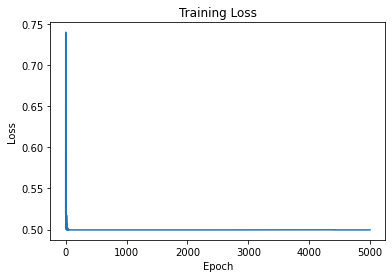

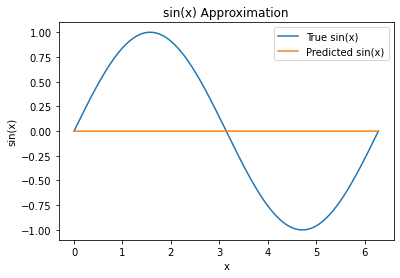

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate training data
x = np.linspace(0, 2*np.pi, 1000)
y = np.sin(x)

# Convert data to PyTorch tensors
x_tensor = torch.tensor(x.reshape(-1, 1, 1), dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1, 1, 1), dtype=torch.float32)

# Define the RNN model
class RNNSin(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNSin, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input):
        output, _ = self.rnn(input)
        output = self.fc(output[:, -1, :])
        return output

# Set hyperparameters
input_size = 1
hidden_size = 200
output_size = 1
learning_rate = 0.01
num_epochs = 5000

# Initialize the RNN model
model = RNNSin(input_size, hidden_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
losses = []
for epoch in range(num_epochs):
    # Forward pass
    output = model(x_tensor)
    loss = criterion(output, y_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Store the loss
    losses.append(loss.item())

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Test the model
x_test = np.linspace(0, 2*np.pi, 200)
x_test_tensor = torch.tensor(x_test.reshape(-1, 1, 1), dtype=torch.float32)
with torch.no_grad():
    y_pred = model(x_test_tensor)

# Plot the true sin(x) and predicted sin(x)
plt.plot(x, y, label='True sin(x)')
plt.plot(x_test, y_pred.squeeze().numpy(), label='Predicted sin(x)')
plt.legend()
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('sin(x) Approximation')
plt.show()


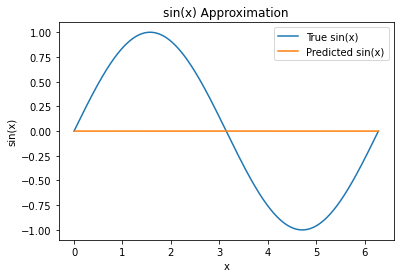

In [6]:

# Test the model
x_test = np.linspace(0, 2*np.pi, 100)
x_test_tensor = torch.tensor(x_test.reshape(-1, 1, 1), dtype=torch.float32)
with torch.no_grad():
    y_pred = model(x_test_tensor)

# Plot the true sin(x) and predicted sin(x)
plt.plot(x, y, label='True sin(x)')
plt.plot(x_test, y_pred.squeeze().numpy(), label='Predicted sin(x)')
plt.legend()
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('sin(x) Approximation')
plt.show()


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100, 1, 1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/500], Loss: 0.4975
Epoch [20/500], Loss: 0.4968
Epoch [30/500], Loss: 0.4954
Epoch [40/500], Loss: 0.4952
Epoch [50/500], Loss: 0.4951
Epoch [60/500], Loss: 0.4950
Epoch [70/500], Loss: 0.4950
Epoch [80/500], Loss: 0.4950
Epoch [90/500], Loss: 0.4950
Epoch [100/500], Loss: 0.4950
Epoch [110/500], Loss: 0.4950
Epoch [120/500], Loss: 0.4950
Epoch [130/500], Loss: 0.4950
Epoch [140/500], Loss: 0.4950
Epoch [150/500], Loss: 0.4950
Epoch [160/500], Loss: 0.4950
Epoch [170/500], Loss: 0.4950
Epoch [180/500], Loss: 0.4950
Epoch [190/500], Loss: 0.4950
Epoch [200/500], Loss: 0.4950
Epoch [210/500], Loss: 0.4950
Epoch [220/500], Loss: 0.4950
Epoch [230/500], Loss: 0.4950
Epoch [240/500], Loss: 0.4950
Epoch [250/500], Loss: 0.4950
Epoch [260/500], Loss: 0.4950
Epoch [270/500], Loss: 0.4950
Epoch [280/500], Loss: 0.4950
Epoch [290/500], Loss: 0.4950
Epoch [300/500], Loss: 0.4950
Epoch [310/500], Loss: 0.4950
Epoch [320/500], Loss: 0.4950
Epoch [330/500], Loss: 0.4950
Epoch [340/500], Lo

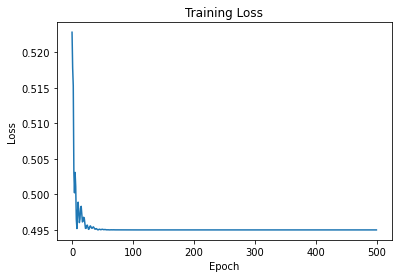

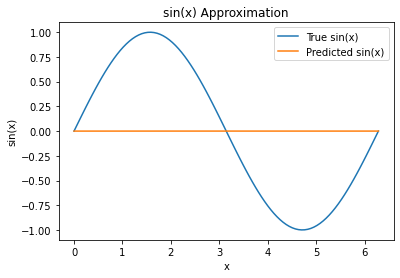

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate training data
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

# Convert data to PyTorch tensors
x_tensor = torch.tensor(x.reshape(-1, 1, 1), dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1, 1, 1), dtype=torch.float32)

# Define the RNN model
class RNNSin(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNSin, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.init_hidden(batch_size)
        output, _ = self.rnn(input, hidden)
        output = self.fc(output[:, -1, :])
        return output
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.hidden_size)
        return hidden

# Set hyperparameters
input_size = 1
hidden_size = 32
output_size = 1
learning_rate = 0.01
num_epochs = 500

# Initialize the RNN model
model = RNNSin(input_size, hidden_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
losses = []
for epoch in range(num_epochs):
    # Forward pass
    output = model(x_tensor)
    loss = criterion(output, y_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Store the loss
    losses.append(loss.item())

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Test the model
x_test = np.linspace(0, 2*np.pi, 200)
x_test_tensor = torch.tensor(x_test.reshape(-1, 1, 1), dtype=torch.float32)
with torch.no_grad():
    y_pred = model(x_test_tensor)

# Plot the true sin(x) and predicted sin(x)
plt.plot(x, y, label='True sin(x)')
plt.plot(x_test, y_pred.squeeze().numpy(), label='Predicted sin(x)')
plt.legend()
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('sin(x) Approximation')
plt.show()


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100, 1, 1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/500], Loss: 0.4960
Epoch [20/500], Loss: 0.4982
Epoch [30/500], Loss: 0.4981
Epoch [40/500], Loss: 0.4966
Epoch [50/500], Loss: 0.4955
Epoch [60/500], Loss: 0.4951
Epoch [70/500], Loss: 0.4951
Epoch [80/500], Loss: 0.4950
Epoch [90/500], Loss: 0.4950
Epoch [100/500], Loss: 0.4950
Epoch [110/500], Loss: 0.4950
Epoch [120/500], Loss: 0.4950
Epoch [130/500], Loss: 0.4950
Epoch [140/500], Loss: 0.4950
Epoch [150/500], Loss: 0.4950
Epoch [160/500], Loss: 0.4950
Epoch [170/500], Loss: 0.4950
Epoch [180/500], Loss: 0.4950
Epoch [190/500], Loss: 0.4950
Epoch [200/500], Loss: 0.4950
Epoch [210/500], Loss: 0.4950
Epoch [220/500], Loss: 0.4950
Epoch [230/500], Loss: 0.4950
Epoch [240/500], Loss: 0.4950
Epoch [250/500], Loss: 0.4950
Epoch [260/500], Loss: 0.4950
Epoch [270/500], Loss: 0.4950
Epoch [280/500], Loss: 0.4950
Epoch [290/500], Loss: 0.4950
Epoch [300/500], Loss: 0.4950
Epoch [310/500], Loss: 0.4950
Epoch [320/500], Loss: 0.4950
Epoch [330/500], Loss: 0.4950
Epoch [340/500], Lo

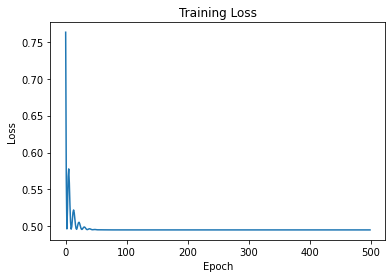

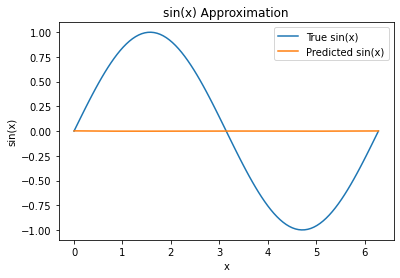

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate training data
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

# Scale the input data
x_scaled = (x - np.pi) / np.pi * 10

# Convert data to PyTorch tensors
x_tensor = torch.tensor(x_scaled.reshape(-1, 1, 1), dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1, 1, 1), dtype=torch.float32)

# Define the RNN model
class RNNSin(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNSin, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.init_hidden(batch_size)
        output, _ = self.rnn(input, hidden)
        output = self.fc(output[:, -1, :])
        return output
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.hidden_size)
        return hidden

# Set hyperparameters
input_size = 1
hidden_size = 32
output_size = 1
learning_rate = 0.01
num_epochs = 500

# Initialize the RNN model
model = RNNSin(input_size, hidden_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
losses = []
for epoch in range(num_epochs):
    # Forward pass
    output = model(x_tensor)
    loss = criterion(output, y_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Store the loss
    losses.append(loss.item())

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Test the model
x_test = np.linspace(0, 2*np.pi, 200)
x_test_scaled = (x_test - np.pi) / np.pi * 10
x_test_tensor = torch.tensor(x_test_scaled.reshape(-1, 1, 1), dtype=torch.float32)
with torch.no_grad():
    y_pred = model(x_test_tensor)

# Plot the true sin(x) and predicted sin(x)
plt.plot(x, y, label='True sin(x)')
plt.plot(x_test, y_pred.squeeze().numpy(), label='Predicted sin(x)')
plt.legend()
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('sin(x) Approximation')
plt.show()


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100, 1, 1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/5000], Loss: 0.4989
Epoch [20/5000], Loss: 0.4986
Epoch [30/5000], Loss: 0.4982
Epoch [40/5000], Loss: 0.4980
Epoch [50/5000], Loss: 0.4977
Epoch [60/5000], Loss: 0.4974
Epoch [70/5000], Loss: 0.4972
Epoch [80/5000], Loss: 0.4970
Epoch [90/5000], Loss: 0.4968
Epoch [100/5000], Loss: 0.4967
Epoch [110/5000], Loss: 0.4965
Epoch [120/5000], Loss: 0.4964
Epoch [130/5000], Loss: 0.4963
Epoch [140/5000], Loss: 0.4962
Epoch [150/5000], Loss: 0.4961
Epoch [160/5000], Loss: 0.4960
Epoch [170/5000], Loss: 0.4959
Epoch [180/5000], Loss: 0.4958
Epoch [190/5000], Loss: 0.4957
Epoch [200/5000], Loss: 0.4957
Epoch [210/5000], Loss: 0.4956
Epoch [220/5000], Loss: 0.4955
Epoch [230/5000], Loss: 0.4955
Epoch [240/5000], Loss: 0.4955
Epoch [250/5000], Loss: 0.4954
Epoch [260/5000], Loss: 0.4954
Epoch [270/5000], Loss: 0.4953
Epoch [280/5000], Loss: 0.4953
Epoch [290/5000], Loss: 0.4953
Epoch [300/5000], Loss: 0.4953
Epoch [310/5000], Loss: 0.4952
Epoch [320/5000], Loss: 0.4952
Epoch [330/5000],

Epoch [2690/5000], Loss: 0.4950
Epoch [2700/5000], Loss: 0.4950
Epoch [2710/5000], Loss: 0.4950
Epoch [2720/5000], Loss: 0.4950
Epoch [2730/5000], Loss: 0.4950
Epoch [2740/5000], Loss: 0.4950
Epoch [2750/5000], Loss: 0.4950
Epoch [2760/5000], Loss: 0.4950
Epoch [2770/5000], Loss: 0.4950
Epoch [2780/5000], Loss: 0.4950
Epoch [2790/5000], Loss: 0.4950
Epoch [2800/5000], Loss: 0.4950
Epoch [2810/5000], Loss: 0.4950
Epoch [2820/5000], Loss: 0.4950
Epoch [2830/5000], Loss: 0.4950
Epoch [2840/5000], Loss: 0.4950
Epoch [2850/5000], Loss: 0.4950
Epoch [2860/5000], Loss: 0.4950
Epoch [2870/5000], Loss: 0.4950
Epoch [2880/5000], Loss: 0.4950
Epoch [2890/5000], Loss: 0.4950
Epoch [2900/5000], Loss: 0.4950
Epoch [2910/5000], Loss: 0.4950
Epoch [2920/5000], Loss: 0.4950
Epoch [2930/5000], Loss: 0.4950
Epoch [2940/5000], Loss: 0.4950
Epoch [2950/5000], Loss: 0.4950
Epoch [2960/5000], Loss: 0.4950
Epoch [2970/5000], Loss: 0.4950
Epoch [2980/5000], Loss: 0.4950
Epoch [2990/5000], Loss: 0.4950
Epoch [3

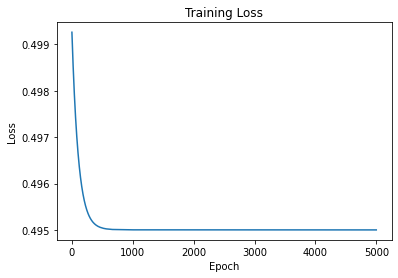

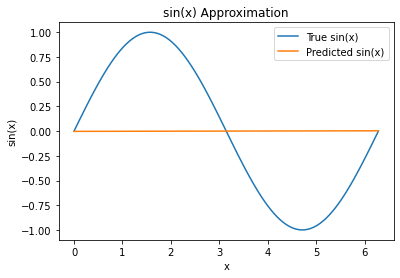

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate training data
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

# Scale the input data
x_scaled = (x - np.pi) /  10

# Convert data to PyTorch tensors
x_tensor = torch.tensor(x_scaled.reshape(-1, 1, 1), dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1, 1, 1), dtype=torch.float32)

# Define the RNN model
class RNNSin(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNSin, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.init_hidden(batch_size)
        output, _ = self.rnn(input, hidden)
        output = self.fc(output[:, -1, :])
        return output
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.hidden_size)
        return hidden

# Set hyperparameters
input_size = 1
hidden_size = 200  # Increased hidden size
output_size = 1
learning_rate = 0.001  # Adjusted learning rate
num_epochs = 5000

# Initialize the RNN model
model = RNNSin(input_size, hidden_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # Changed optimizer to SGD

# Training loop
losses = []
for epoch in range(num_epochs):
    # Forward pass
    output = model(x_tensor)
    loss = criterion(output, y_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Store the loss
    losses.append(loss.item())

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Test the model
x_test = np.linspace(0, 2*np.pi, 200)
x_test_scaled = (x_test - np.pi) / 10
x_test_tensor = torch.tensor(x_test_scaled.reshape(-1, 1, 1), dtype=torch.float32)
with torch.no_grad():
    y_pred = model(x_test_tensor)

# Plot the true sin(x) and predicted sin(x)
plt.plot(x, y, label='True sin(x)')
plt.plot(x_test, y_pred.squeeze().numpy(), label='Predicted sin(x)')
plt.legend()
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('sin(x) Approximation')
plt.show()


Epoch: 0 loss: 0.0004100106889382005 test loss: 0.00023189325293060392
Epoch: 1 loss: 2.8032579848513706e-06 test loss: 1.7793232700569206e-06
Epoch: 2 loss: 4.95620270157815e-0776 test loss: 4.778641482516832e-07
Epoch: 3 loss: 3.148060727653501e-077 test loss: 3.102063033111335e-07
Epoch: 4 loss: 3.051802366371703e-077 test loss: 3.051802366371703e-07
Epoch: 5 loss: 3.0474313916784013e-07 test loss: 3.047454697480134e-07
Epoch: 6 loss: 3.0474313916784013e-07 test loss: 3.047454697480134e-07
Epoch: 7 loss: 3.0474313916784013e-07 test loss: 3.047454697480134e-07
Epoch: 8 loss: 3.0474313916784013e-07 test loss: 3.047454697480134e-07
Epoch: 9 loss: 3.0474313916784013e-07 test loss: 3.047454697480134e-07
Epoch: 10 loss: 3.0474313916784013e-07 test loss: 3.047454697480134e-07
Epoch: 11 loss: 3.0474313916784013e-07 test loss: 3.047454697480134e-07
Epoch: 12 loss: 3.0474313916784013e-07 test loss: 3.047454697480134e-07
Epoch: 13 loss: 3.0474313916784013e-07 test loss: 3.047454697480134e-07
E

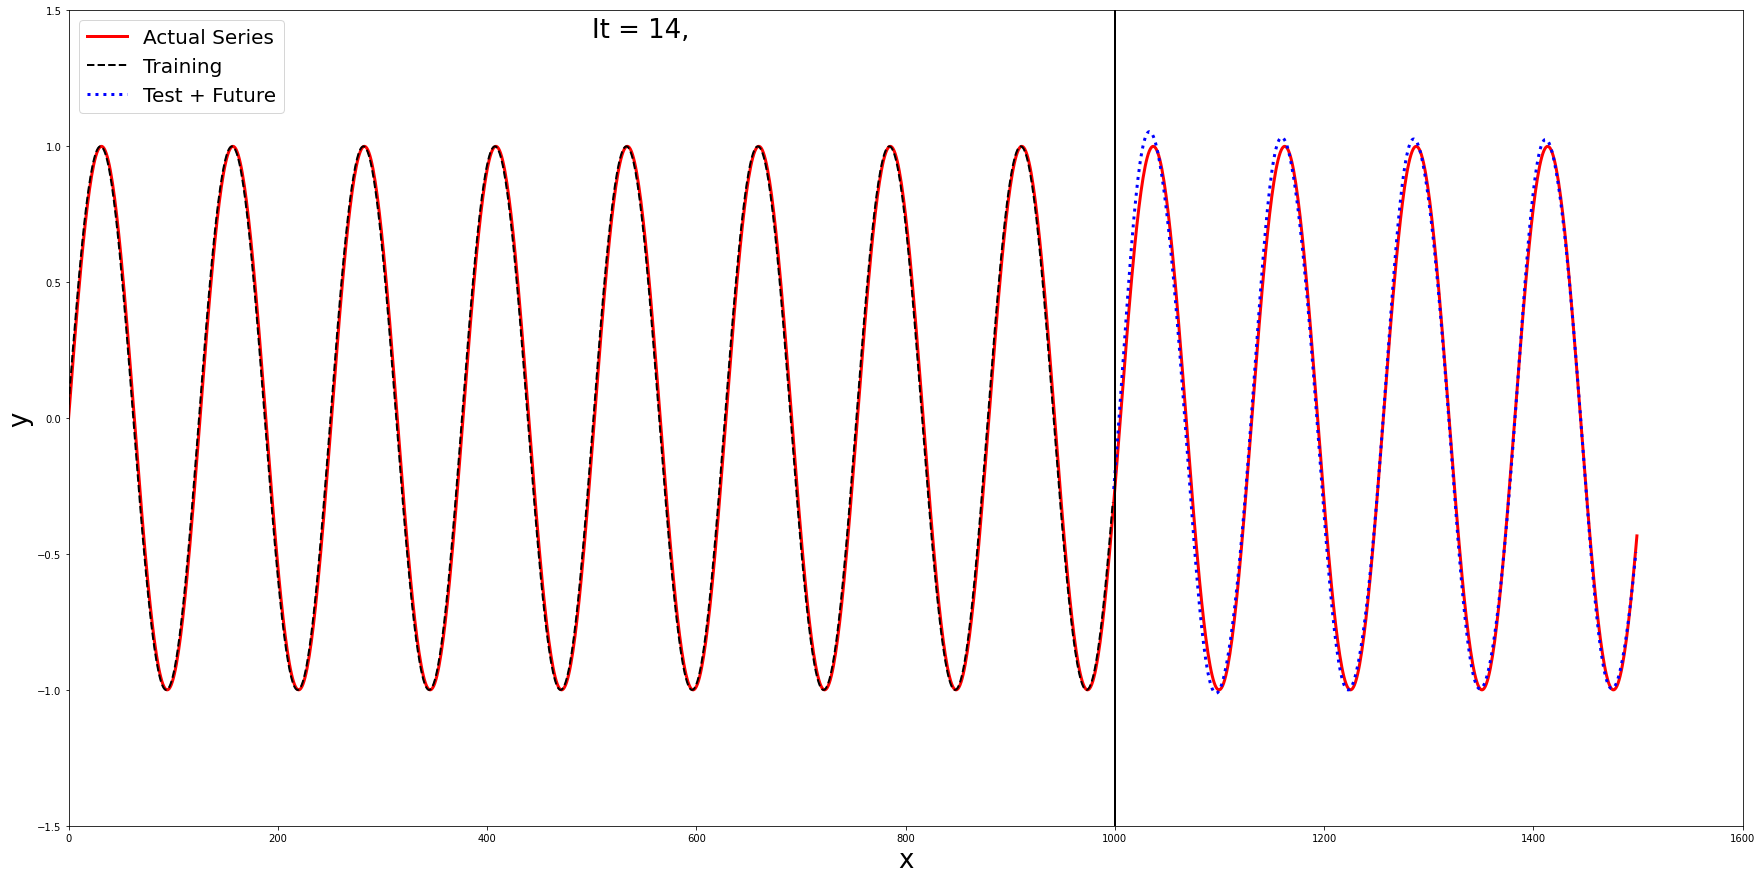

In [13]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim



SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

### Property of Sin function


T = 20 # Period of Sin Function
L = 1000 # Sample Lenght of Sin function
N = 200   # Sequence Length


x = np.empty((N, L), 'int32')
x[:] = np.array(range(L))
data = np.sin(x * (1.0 / T)).astype('float32')
x_f = np.array(range(1500))
data_f = np.sin(x_f * (1.0 / T)).astype('float32')

train_data = torch.from_numpy(data[1:, :-1])
train_target = torch.from_numpy(data[1:, 1:])
test_data = torch.from_numpy(data[:1, :-1])
test_target = torch.from_numpy(data[:1, 1:])



class RNNSin(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super(RNNSin, self).__init__()
        self.rnn = nn.RNNCell(in_dim, h_dim)
        self.linear = nn.Linear(h_dim, out_dim)
        self.h_dim = h_dim

    def forward(self, train_data, future = 0):
        outputs = []        
        h_t = torch.zeros((train_data.size(0),self.h_dim))
        for i, input_t in enumerate(train_data.chunk(train_data.size(1), dim=1)):
            h_t = self.rnn(input_t,h_t)
            output = self.linear(h_t)
            outputs.append(output)
        for i in range(future):            
            h_t = self.rnn(outputs[-1],h_t)
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

    
seq = RNNSin(1,200,1)
loss_fn = nn.MSELoss()
optimizer = optim.LBFGS(seq.parameters(), lr=0.4)
Nepochs = 15

fig, ax = plt.subplots(figsize=(30,15))
image_list = []
for it in range(Nepochs):
    
    
    def closure():
        optimizer.zero_grad()
        out = seq(train_data)
        loss = loss_fn(out, train_target)
        print('\rEpoch:', it,'loss:', loss.item(), end='')
        loss.backward()
        return loss
    optimizer.step(closure)
    
    future = 500
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred = seq(test_data, future=future)
        loss = loss_fn(pred[:, :-future], test_target)
        print(' test loss:', loss.item())
        y = pred.detach().numpy()
    plt.cla()
    ax.set_xlabel('x', fontsize=26)
    ax.set_ylabel('y', fontsize=26)
    ax.set_xlim([0,1600])
    ax.set_ylim([-1.5, 1.5])
    ax.plot(x_f, data_f, "-r", linewidth = 3.0, label="Actual Series")
    ax.plot(np.arange(train_data.size(1)), y[0][:train_data.size(1)], '--k', linewidth = 2.0, label="Training")
    ax.plot(np.arange(train_data.size(1), train_data.size(1) + future), y[0][train_data.size(1):], 'b' + ':', linewidth = 3.0, label="Test + Future")
    ax.vlines(1000, -1.5, 1.5, colors="black", linestyles='solid', linewidth=2.0)   
    ax.text(500.0, 1.4, 'It = %d,' %it, fontdict={'size': 26, 'color':  'black'})
    plt.legend(loc=2, prop={'size': 20})
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    image_list.append(image)

In [27]:
m = seq(train_data)
m.shape

torch.Size([199, 999])

In [14]:
print(train_data.shape)

torch.Size([199, 999])


In [15]:
print(test_data.shape)

torch.Size([1, 999])


In [16]:
print(train_target.shape)

torch.Size([199, 999])


In [17]:
print(test_target.shape)

torch.Size([1, 999])


In [18]:
x.shape

(200, 1000)

In [21]:
train_data.size(1)

999

In [24]:
y[0][:train_data.size(1)].shape

(999,)

In [25]:
y[0].shape

(1499,)

In [28]:
seq

RNNSin(
  (rnn): RNNCell(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)

Epoch: 0 loss: 0.0017511987825855613 test loss: 0.0016670176992192864
Epoch: 1 loss: 0.0005029616877436638 test loss: 0.00047140821698121727
Epoch: 2 loss: 5.547151522478089e-055 test loss: 5.393323226599023e-05
Epoch: 3 loss: 1.2755008356180042e-05 test loss: 1.1619599717960227e-05
Epoch: 4 loss: 2.75086858891882e-0666 test loss: 2.6940351744997315e-06
Epoch: 5 loss: 5.997751486574998e-076 test loss: 5.863431056241097e-07
Epoch: 6 loss: 2.6503914796194294e-07 test loss: 2.650358226219396e-07
Epoch: 7 loss: 2.6503914796194294e-07 test loss: 2.650358226219396e-07
Epoch: 8 loss: 2.6503914796194294e-07 test loss: 2.650358226219396e-07
Epoch: 9 loss: 2.6503914796194294e-07 test loss: 2.650358226219396e-07
Epoch: 10 loss: 2.6503914796194294e-07 test loss: 2.650358226219396e-07
Epoch: 11 loss: 2.6503914796194294e-07 test loss: 2.650358226219396e-07
Epoch: 12 loss: 2.6503914796194294e-07 test loss: 2.650358226219396e-07
Epoch: 13 loss: 2.6503914796194294e-07 test loss: 2.650358226219396e-07
E

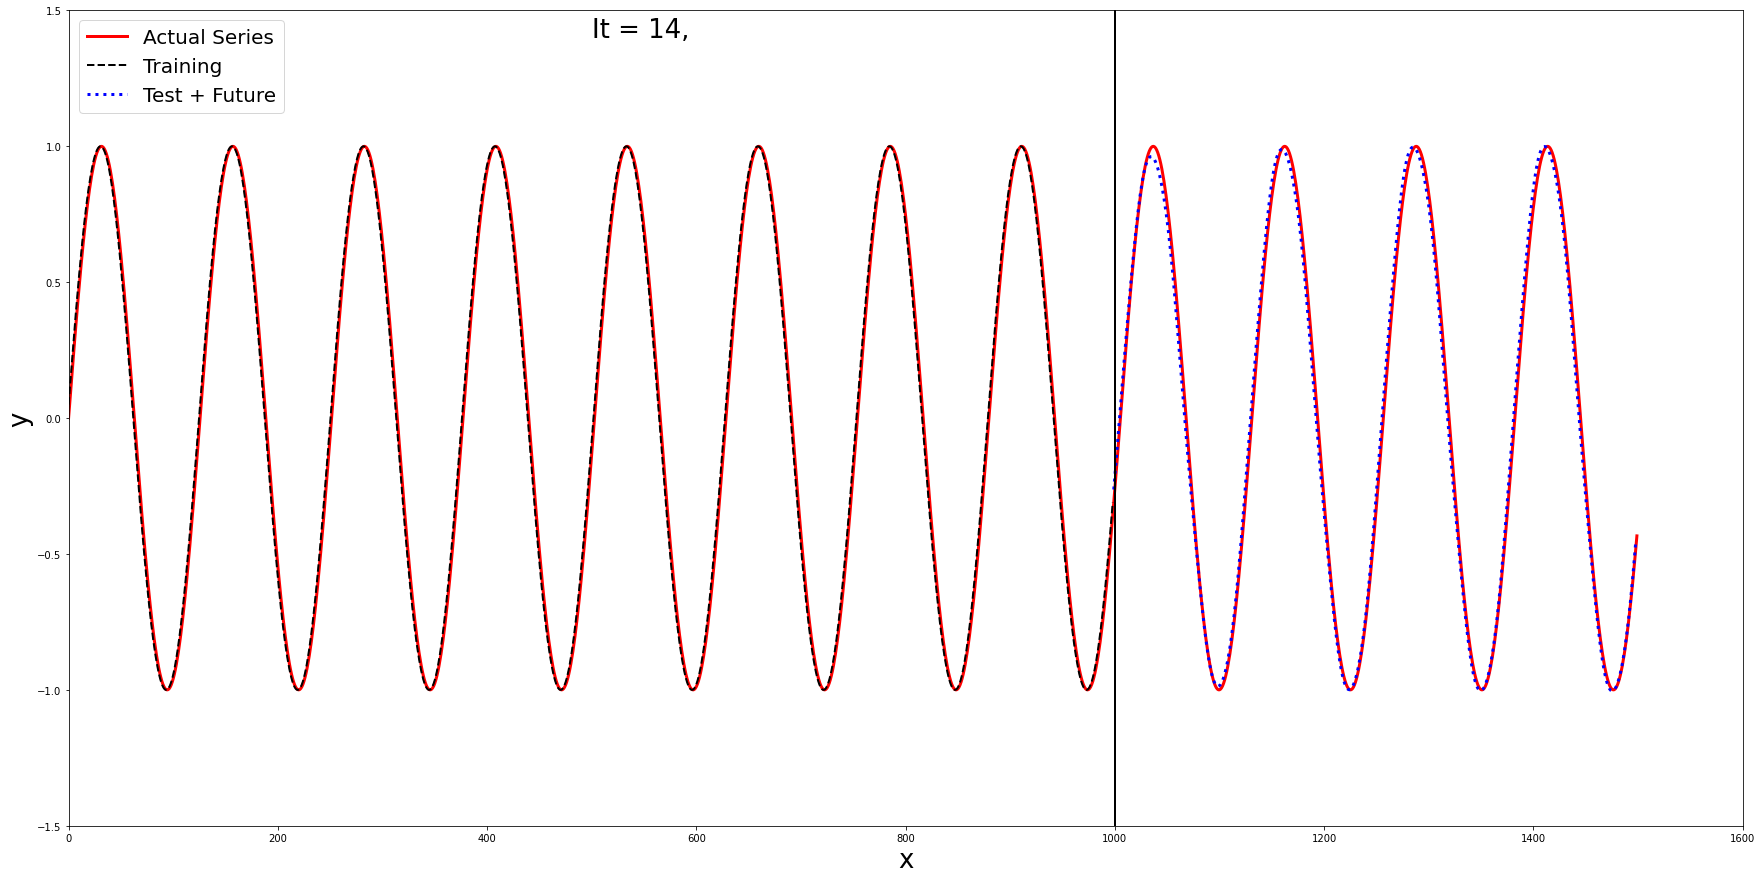

In [31]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim


SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)


### Property of Sin function

T = 20  # Period of Sin Function
L = 1000  # Sample Length of Sin function
N = 200  # Sequence Length

x = np.empty((N, L), 'int32')
x[:] = np.array(range(L))
data = np.sin(x * (1.0 / T)).astype('float32')
x_f = np.array(range(1500))
data_f = np.sin(x_f * (1.0 / T)).astype('float32')

train_data = torch.from_numpy(data[1:, :-1])
train_target = torch.from_numpy(data[1:, 1:])
test_data = torch.from_numpy(data[:1, :-1])
test_target = torch.from_numpy(data[:1, 1:])


class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.Tensor(hidden_size))
        self.bias_hh = nn.Parameter(torch.Tensor(hidden_size))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight_ih, a=np.sqrt(5))
        nn.init.kaiming_uniform_(self.weight_hh, a=np.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight_ih)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.bias_ih, -bound, bound)
        nn.init.uniform_(self.bias_hh, -bound, bound)

    def forward(self, input, hx):
        gate = torch.matmul(input, self.weight_ih.t()) + self.bias_ih + torch.matmul(hx, self.weight_hh.t()) + self.bias_hh
        hx = torch.tanh(gate)
        return hx


class RNNSin(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super(RNNSin, self).__init__()
        self.rnn = RNNCell(in_dim, h_dim)
        self.linear = nn.Linear(h_dim, out_dim)
        self.h_dim = h_dim

    def forward(self, train_data, future=0):
        outputs = []
        h_t = torch.zeros((train_data.size(0), self.h_dim))
        for i, input_t in enumerate(train_data.chunk(train_data.size(1), dim=1)):
            h_t = self.rnn(input_t, h_t)
            output = self.linear(h_t)
            outputs.append(output)
        for i in range(future):
            h_t = self.rnn(outputs[-1], h_t)
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs


seq = RNNSin(1, 200, 1)
loss_fn = nn.MSELoss()
optimizer = optim.LBFGS(seq.parameters(), lr=0.4)
Nepochs = 15

fig, ax = plt.subplots(figsize=(30, 15))
image_list = []
for it in range(Nepochs):
    def closure():
        optimizer.zero_grad()
        out = seq(train_data)
        loss = loss_fn(out, train_target)
        print('\rEpoch:', it, 'loss:', loss.item(), end='')
        loss.backward()
        return loss

    optimizer.step(closure)

    future = 500
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred = seq(test_data, future=future)
        loss = loss_fn(pred[:, :-future], test_target)
        print(' test loss:', loss.item())
        y = pred.detach().numpy()
    plt.cla()
    ax.set_xlabel('x', fontsize=26)
    ax.set_ylabel('y', fontsize=26)
    ax.set_xlim([0, 1600])
    ax.set_ylim([-1.5, 1.5])
    ax.plot(x_f, data_f, "-r", linewidth=3.0, label="Actual Series")
    ax.plot(np.arange(train_data.size(1)), y[0][:train_data.size(1)], '--k', linewidth=2.0, label="Training")
    ax.plot(
        np.arange(train_data.size(1), train_data.size(1) + future),
        y[0][train_data.size(1):],
        'b' + ':',
        linewidth=3.0,
        label="Test + Future"
    )
    ax.vlines(1000, -1.5, 1.5, colors="black", linestyles='solid', linewidth=2.0)
    ax.text(500.0, 1.4, 'It = %d,' % it, fontdict={'size': 26, 'color': 'black'})
    plt.legend(loc=2, prop={'size': 20})
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    image_list.append(image)
